# UTS Pembelajaran Mendalam  
## Klasifikasi Makanan Khas Daerah Indonesia dengan CNN Kustom

Kelompok: A_KERAS  
Kelas: A  
Tema: Keanekaragaman Budaya Nusantara (Kategori: Makanan Tradisional)

Kelas yang diklasifikasikan:
1. Bika Ambon
2. Kerak Telur
3. Papeda
4. Plecing Kangkung

### Dataset
- Dataset dikumpulkan mandiri dari Internet / mesin pencari, bukan dataset Kaggle.
- Masing-masing kelas memiliki ~75 gambar dengan variasi sudut, pencahayaan, latar belakang, kondisi penyajian.
- Dataset dipisahkan menjadi:
  - Train: 80%
  - Validation: 10%
  - Test: 10%
- Masing-masing kelas di test set berisi 8 gambar, total 32 gambar.
- Disiapkan juga folder `predict_samples/` berisi gambar baru (tidak termasuk train/val/test) untuk uji inferensi model akhir.

- Link dataset: https://drive.google.com/drive/folders/1YwwKYx5nVoIPzTuQqHL_8tHS0heYF8A0?usp=sharing
- Link repo GitHub: https://github.com/Yntzie/Projek-UAS-PMDPM_A_KERAS  
- Link aplikasi Streamlit (deployment): [ISI LINK STREAMLIT NANTI]


## 1. Import Library dan Konfigurasi Awal

Pada bagian ini kami:
- Mengimpor seluruh library yang diperlukan (TensorFlow, NumPy, Matplotlib, dsb).
- Mendefinisikan path dataset untuk train / val / test.
- Mendefinisikan hyperparameter seperti ukuran gambar, ukuran batch, jumlah epoch.
- Menentukan urutan kelas (`CLASS_NAMES_ORDER`) yang akan digunakan untuk interpretasi hasil prediksi.


In [1]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 1 – Import Library & Konfigurasi
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

layers = tf.keras.layers
models = tf.keras.models

In [45]:
import os

BASE_DIR = r"D:\Projek-UAS-PMDPM_A_KERAS\dataset"  # lokasi folder DATASET kamu

CLASS_NAMES = ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']
SPLITS = ['train', 'val', 'test']

def count_images_in_folder(folder):
    if not os.path.isdir(folder):
        return 0
    return sum(
        1
        for f in os.listdir(folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    )

# hitung per kelas, per split
counts = {cls: {split: 0 for split in SPLITS} for cls in CLASS_NAMES}
total_per_class = {cls: 0 for cls in CLASS_NAMES}

for cls in CLASS_NAMES:
    for split in SPLITS:
        folder = os.path.join(BASE_DIR, split, cls)
        n = count_images_in_folder(folder)
        counts[cls][split] = n
        total_per_class[cls] += n

# print ringkas
print("=== RINCIAN DATASET PER KELAS ===")
for cls in CLASS_NAMES:
    print(f"\nKelas: {cls}")
    for split in SPLITS:
        print(f"  {split:5s}: {counts[cls][split]} file")
    print(f"  TOTAL : {total_per_class[cls]} file")

print("\n=== RANGKUMAN CEPAT ===")
for cls in CLASS_NAMES:
    print(f"{cls:17s} -> {total_per_class[cls]} file")

print("\nKELAS TERBESAR & TERKECIL:")
max_class = max(total_per_class, key=lambda c: total_per_class[c])
min_class = min(total_per_class, key=lambda c: total_per_class[c])
print(f"  Terbanyak : {max_class} ({total_per_class[max_class]} file)")
print(f"  Tersedikit: {min_class} ({total_per_class[min_class]} file)")


=== RINCIAN DATASET PER KELAS ===

Kelas: bika ambon
  train: 160 file
  val  : 20 file
  test : 20 file
  TOTAL : 200 file

Kelas: kerak telur
  train: 160 file
  val  : 20 file
  test : 20 file
  TOTAL : 200 file

Kelas: papeda
  train: 160 file
  val  : 20 file
  test : 20 file
  TOTAL : 200 file

Kelas: plecing kangkung
  train: 160 file
  val  : 20 file
  test : 20 file
  TOTAL : 200 file

=== RANGKUMAN CEPAT ===
bika ambon        -> 200 file
kerak telur       -> 200 file
papeda            -> 200 file
plecing kangkung  -> 200 file

KELAS TERBESAR & TERKECIL:
  Terbanyak : bika ambon (200 file)
  Tersedikit: bika ambon (200 file)


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:

# Paths dataset
train_dir = "../dataset/train"
val_dir   = "../dataset/val"
test_dir  = "../dataset/test"

# Hyperparameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

# Urutan nama kelas sesuai folder
CLASS_NAMES_ORDER = ["bika ambon", "kerak telur", "papeda", "plecing kangkung"]

print("TensorFlow version:", tf.__version__)
print("Kelas:", CLASS_NAMES_ORDER)


TensorFlow version: 2.20.0
Kelas: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


In [4]:
allowed_ext = [".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"]
root_dirs = [train_dir, val_dir, test_dir]

for root_dir in root_dirs:
    for kelas in os.listdir(root_dir):
        class_path = os.path.join(root_dir, kelas)
        if not os.path.isdir(class_path):
            continue
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            # hapus subfolder di dalam kelas
            if os.path.isdir(fpath):
                print("⚠ Ada subfolder dalam kelas (hapus manual):", fpath)
            else:
                ext = os.path.splitext(fname)[1].lower()
                if ext not in allowed_ext:
                    print("🗑 hapus file non-gambar:", fpath)
                    os.remove(fpath)


## 2. Data Loading

Kami membuat fungsi `load_data()` yang bertugas untuk:
1. Memuat gambar dari direktori (train / val / test).
2. Mengatur ukuran gambar agar konsisten (`IMG_SIZE`).
3. Mengatur ukuran batch (`BATCH_SIZE`).
4. Menghasilkan objek `tf.data.Dataset` yang sudah berisi pasangan (gambar, label).

Fungsi dengan parameter seperti ini sesuai dengan kriteria penilaian "Data Loading".


In [5]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 2 – Fungsi Data Loading (Rubrik: Data Loading)
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
def load_data(directory, img_size=(224,224), batch_size=32, shuffle=True):
    """
    Meload dataset gambar dari folder.
    Parameter:
        directory   : path folder (train / val / test)
        img_size    : ukuran target gambar (width,height)
        batch_size  : jumlah gambar per batch
        shuffle     : apakah diacak
    Output:
        tf.data.Dataset yang berisi (image_batch, label_batch)
        label diberikan otomatis berdasarkan nama folder kelas
    """
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        labels='inferred',         # label diambil dari nama folder
        label_mode='int',          # integer label (0,1,2,3)
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle
    )
    return dataset

train_ds_raw = load_data(train_dir, IMG_SIZE, BATCH_SIZE, shuffle=True)
val_ds_raw   = load_data(val_dir,   IMG_SIZE, BATCH_SIZE, shuffle=True)
test_ds_raw  = load_data(test_dir,  IMG_SIZE, BATCH_SIZE, shuffle=True)

print("Class names terdeteksi:", train_ds_raw.class_names)


Found 467 files belonging to 4 classes.
Found 61 files belonging to 4 classes.
Found 64 files belonging to 4 classes.
Class names terdeteksi: ['bika ambon', 'kerak telur', 'papeda', 'plecing kangkung']


## 3. Visualisasi Data Mentah (Sampel Gambar per Kelas)

Bagian ini menampilkan beberapa contoh gambar dari dataset training beserta label kelasnya.

Tujuannya:
- Mengecek apakah label sudah benar (misalnya gambar bika ambon memang ada di folder "bika ambon").
- Mengecek apakah gambar bisa dibaca dengan baik (tidak korup).
- Menunjukkan variasi visual data.

Fungsi `visualize_data()` menerima:
- dataset,
- daftar nama kelas,
- jumlah gambar yang ingin ditampilkan.
Ini sesuai rubrik "Data Visualization".


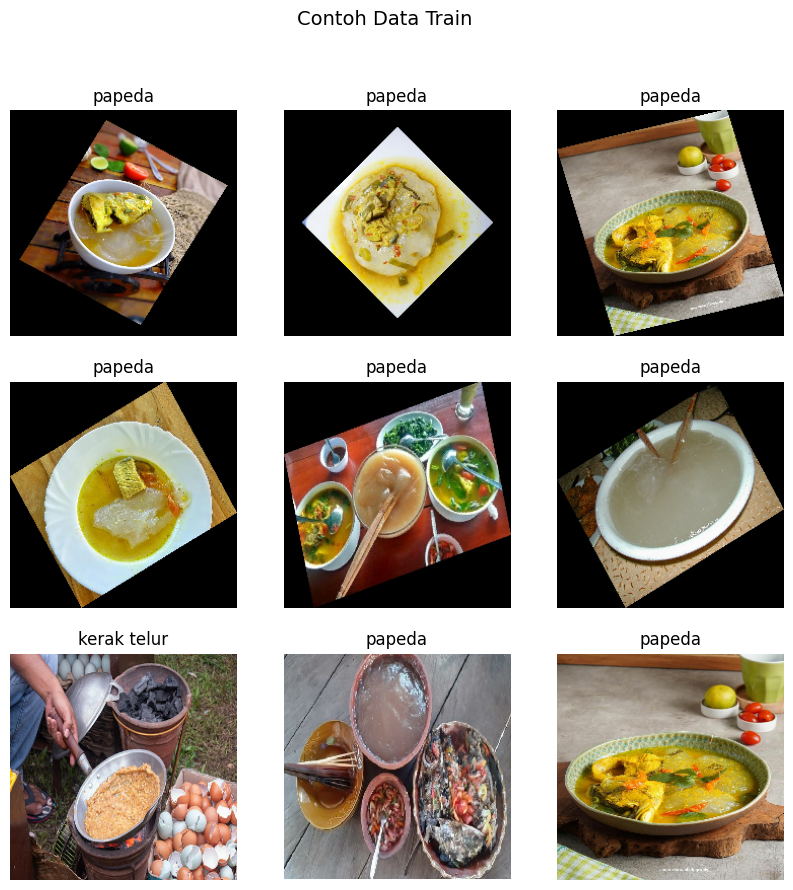

In [6]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 3 – Visualisasi Data (Rubrik: Data Visualization)
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
def visualize_data(dataset, class_names, n_images=9):
    plt.figure(figsize=(10,10))
    for images, labels in dataset.take(1):
        for i in range(n_images):
            ax = plt.subplot(3,3,i+1)
            img = images[i].numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            plt.imshow(img.astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.suptitle("Contoh Data Train", fontsize=14)
    plt.show()

# panggil pakai dataset mentah
visualize_data(train_ds_raw, train_ds_raw.class_names, n_images=9)



## 4. Data Preparation (Normalisasi, Shuffle, Prefetch)

Di tahap ini kami menyiapkan data agar siap dilatih oleh model:
1. Normalisasi piksel dari [0..255] menjadi [0..1] menggunakan `layers.Rescaling(1./255)`.
2. (Opsional) `shuffle()` untuk training agar batch acak.
3. `prefetch()` untuk mempercepat input pipeline saat training.

Selain itu, kami juga menghitung jumlah batch untuk train/val/test.  

In [7]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 4 – Data Preparation (normalisasi, prefetch, ukuran dataset)
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = layers.Rescaling(1./255)

def prepare_dataset(ds, shuffle=False):
    """
    - Normalisasi piksel dari [0..255] jadi [0..1]
    - Optional shuffle
    - Prefetch untuk efisiensi training
    """
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds_raw, shuffle=True)
val_ds   = prepare_dataset(val_ds_raw,   shuffle=False)
test_ds  = prepare_dataset(test_ds_raw,  shuffle=False)

# tampilkan ukuran masing-masing dataset (jumlah batch)
train_batches = tf.data.experimental.cardinality(train_ds_raw).numpy()
val_batches   = tf.data.experimental.cardinality(val_ds_raw).numpy()
test_batches  = tf.data.experimental.cardinality(test_ds_raw).numpy()

print("Jumlah batch train :", train_batches)
print("Jumlah batch val   :", val_batches)
print("Jumlah batch test  :", test_batches)


Jumlah batch train : 15
Jumlah batch val   : 2
Jumlah batch test  : 2


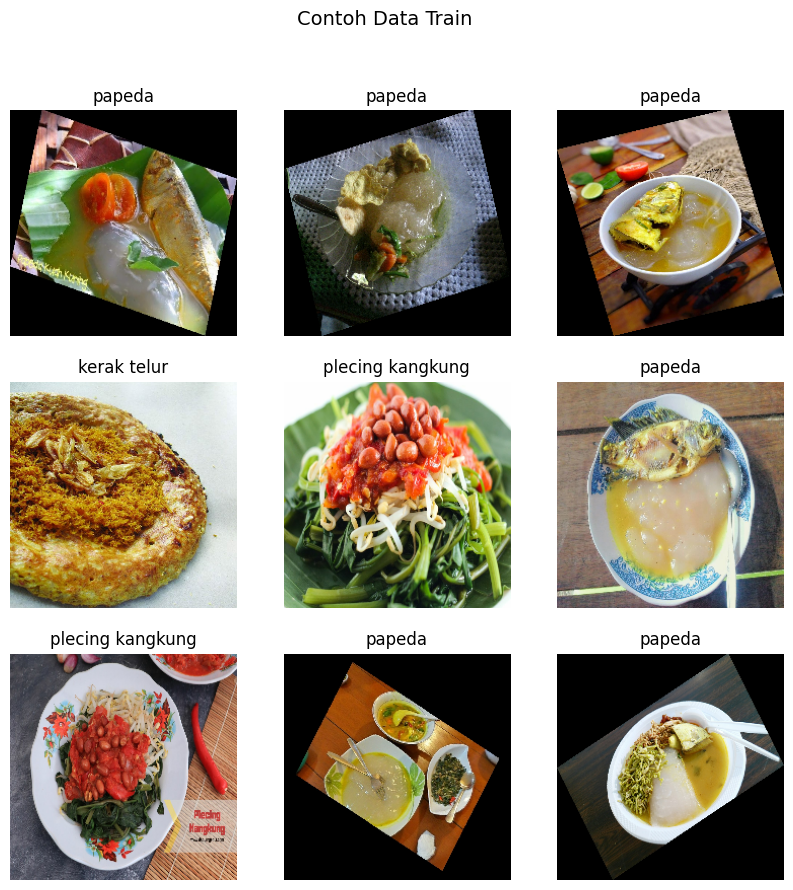

In [8]:
visualize_data(train_ds_raw.map(lambda x,y:(normalization_layer(x),y)),
              train_ds_raw.class_names,
              n_images=9)



## 5. Arsitektur CNN Kustom

Kami membangun arsitektur Convolutional Neural Network (CNN) secara manual tanpa pretrained weights (sesuai aturan UTS).

Struktur utama:
- Beberapa blok Conv2D + MaxPooling untuk mengekstraksi fitur visual.
- Flatten untuk mengubah fitur spasial menjadi vektor.
- Dense + Dropout untuk klasifikasi empat kelas.

`model.summary()` ditampilkan untuk menunjukkan jumlah parameter dan susunan layer.  


In [9]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 5 – Arsitektur Custom CNN (Rubrik: Model Architecture)
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),          # (224,224,3)

    # Block 1
    layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Block 3
    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Block 4 (sedikit lebih dalam supaya model punya representasi fitur lebih kuat)
    layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Classifier head
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(CLASS_NAMES_ORDER), activation='softmax')
])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,234,756 (50.49 MB)

 Trainable params: 13,234,756 (50.49 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Kompilasi Model

Model dikompilasi menggunakan:
- Optimizer: Adam
- Loss: `sparse_categorical_crossentropy` (karena label berupa integer class index)
- Metrik: akurasi

Ini menyiapkan model agar siap untuk proses training.


In [10]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 6 – Compile Model
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',  # karena label integer
    metrics=['accuracy']
)


## 7. Training Model

Model dilatih menggunakan dataset `train_ds` dan divalidasi menggunakan `val_ds` selama sejumlah epoch (`EPOCHS`, di sini 20).

Output dari proses training disimpan dalam variabel `history` yang berisi metrik per epoch.  
Bagian ini memenuhi kriteria "Model Training".


In [11]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 7 – Training Model (Rubrik: Model Training)
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 514ms/step - accuracy: 0.5803 - loss: 1.2793 - val_accuracy: 0.6393 - val_loss: 0.6613
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 487ms/step - accuracy: 0.6552 - loss: 0.6711 - val_accuracy: 0.7213 - val_loss: 0.6634
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 528ms/step - accuracy: 0.6638 - loss: 0.6590 - val_accuracy: 0.6393 - val_loss: 0.6653
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 521ms/step - accuracy: 0.6767 - loss: 0.6471 - val_accuracy: 0.6230 - val_loss: 0.6582
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 539ms/step - accuracy: 0.7345 - loss: 0.6258 - val_accuracy: 0.6721 - val_loss: 0.6280
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 618ms/step - accuracy: 0.7730 - loss: 0.5602 - val_accuracy: 0.8033 - val_loss: 0.4900
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 572ms/step - accuracy: 0.8373 - loss: 0.3843 - val_accuracy: 0.8197 - val_loss: 0.3924
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 543ms/step - accuracy: 0.8779 - loss: 0.3422 - val_accuracy: 

## 8. Evaluasi Proses Training (Accuracy & Loss Curve)

Pada tahap ini kami:
1. Membuat DataFrame berisi nilai akurasi dan loss pada train dan validation di setiap epoch.
2. Membuat dua grafik:
   - Akurasi train vs val
   - Loss train vs val

Interpretasi:
- Jika kurva train dan val bergerak searah dan gap tidak terlalu besar, model tidak overfitting parah.
- Dari grafik kami, akurasi validation (~90%+) mengikuti akurasi train, sehingga model masih generalisasi dengan baik.



In [12]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 8 – Plot Akurasi & Loss (Training vs Validation)
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc)+1)

# Simpan ke DataFrame untuk laporan
history_df = pd.DataFrame({
    "epoch": list(epochs_range),
    "train_accuracy": acc,
    "val_accuracy": val_acc,
    "train_loss": loss,
    "val_loss": val_loss
})
print(history_df)

    epoch  train_accuracy  val_accuracy  train_loss  val_loss
0       1        0.580300      0.639344    1.279286  0.661303
1       2        0.655246      0.721311    0.671137  0.663412
2       3        0.663812      0.639344    0.658965  0.665347
3       4        0.676660      0.622951    0.647075  0.658208
4       5        0.734475      0.672131    0.625832  0.627997
5       6        0.773019      0.803279    0.560186  0.490050
6       7        0.837259      0.819672    0.384320  0.392415
7       8        0.877944      0.868852    0.342196  0.376572
8       9        0.867238      0.885246    0.349237  0.343519
9      10        0.886510      0.803279    0.300476  0.490977
10     11        0.914347      0.868852    0.226215  0.353961
11     12        0.920771      0.918033    0.206519  0.273052
12     13        0.946467      0.885246    0.154302  0.252631
13     14        0.929336      0.885246    0.218743  0.267530
14     15        0.961456      0.950820    0.113589  0.212551
15     1

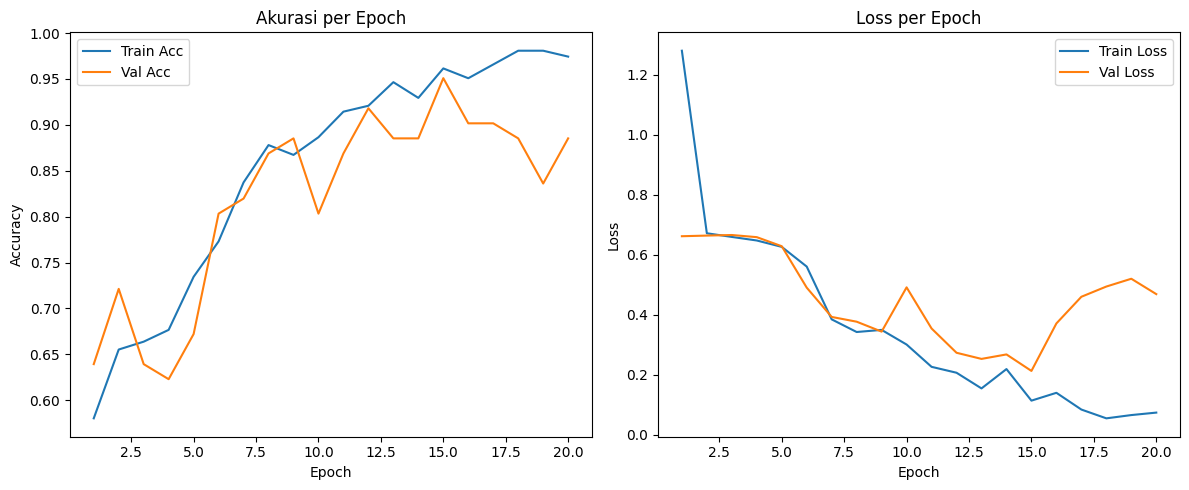

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.title('Akurasi per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 9. Evaluasi pada Test Set

Di sini kami mengevaluasi model menggunakan dataset `test_ds` (data yang tidak dipakai saat training maupun validation).

Metrik yang dilaporkan:
- `Test Loss` : seberapa besar error model pada data baru.
- `Test Acc`  : akurasi klasifikasi di test set.

Ini adalah metrik performa generalisasi model di data yang benar-benar baru.


In [14]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 9 – Evaluasi Model di Test Set
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss :", test_loss)
print("Test Acc  :", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8906 - loss: 0.3556
Test Loss : 0.355561226606369
Test Acc  : 0.890625


## 10. Confusion Matrix dan Classification Report

Kami membuat:
- `classification_report` (precision, recall, f1-score per kelas),
- `confusion_matrix` yang divisualisasikan sebagai heatmap.

Tujuan:
- Melihat kelas mana yang masih sering tertukar.
- Mengecek apakah ada bias (misalnya semua ditebak jadi satu kelas saja).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Classification Report:
                  precision    recall  f1-score   support

      bika ambon       0.70      0.88      0.78         8
     kerak telur       0.86      0.75      0.80         8
          papeda       0.97      0.93      0.95        40
plecing kangkung       0.78      0.88      0.82         8

        accuracy                           0.89        64
       macro avg       0.83      0.86      0.84        64
    weighted avg       0.90      0.89      0.89        64



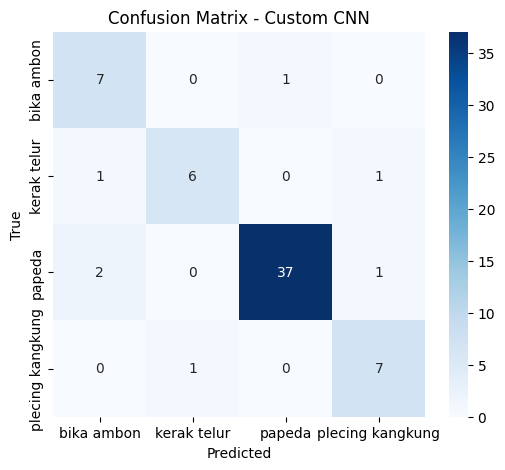

In [15]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 10 – Confusion Matrix & Classification Report (Rubrik: Model Evaluation)
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES_ORDER))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=CLASS_NAMES_ORDER,
            yticklabels=CLASS_NAMES_ORDER)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Custom CNN")
plt.show()


## 11. Visualisasi Prediksi Model pada Data Test

Bagian ini menampilkan beberapa sampel gambar test berikut:
- Label asli (T: ...)
- Label prediksi model (P: ...)
- Confidence (persentase probabilitas tertinggi)

Kami menampilkan gambar asli (bukan tensor yang sudah dinormalisasi) agar tampilan jelas. 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


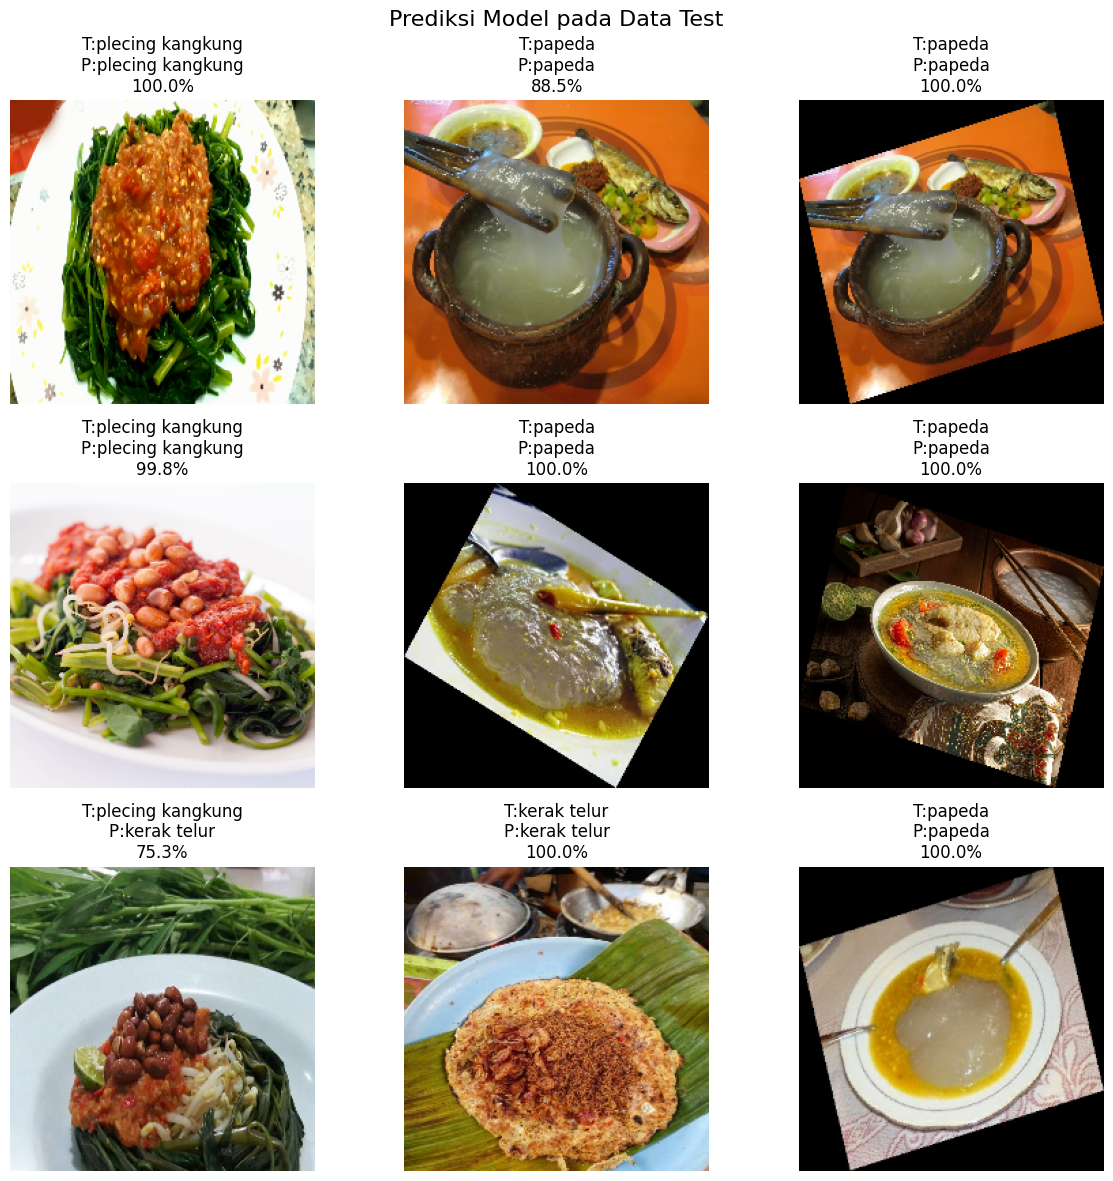

In [16]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 11 – Visualisasi Prediksi Tiap Gambar (Rubrik: Model Prediction)
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
for images, labels in test_ds_raw.take(1):
    # Ambil batch aslinya (belum dinormalisasi)
    raw_imgs = images.numpy()                    
    raw_uint8 = raw_imgs.astype("uint8")        

    # Siapkan batch untuk prediksi (dinormalisasi)
    imgs_for_model = raw_imgs / 255.0             
    probs = model.predict(imgs_for_model)  
    preds = np.argmax(probs, axis=1)

    plt.figure(figsize=(12,12))
    for i in range(min(9, len(raw_uint8))):
        plt.subplot(3,3,i+1)

        # menampilkan gambar asli (bukan hasil normalisasi!)
        plt.imshow(raw_uint8[i])

        true_label = CLASS_NAMES_ORDER[labels[i].numpy()]
        pred_label = CLASS_NAMES_ORDER[preds[i]]
        conf = np.max(probs[i]) * 100

        plt.title(f"T:{true_label}\nP:{pred_label}\n{conf:.1f}%")
        plt.axis("off")

    plt.suptitle("Prediksi Model pada Data Test", fontsize=16)
    plt.tight_layout()
    plt.show()




## 12. Prediksi Gambar Baru (Gambar di Luar Dataset Train/Val/Test)

Di tahap ini kami membuat fungsi `predict_single_image()`.

Fungsi ini:
1. Load 1 gambar dari folder `predict_samples/...`.
2. Resize dan normalisasi gambar.
3. Memanggil `model.predict()` untuk mendapatkan probabilitas setiap kelas.
4. Menentukan kelas dengan probabilitas tertinggi, lalu menampilkan confidence.

Kami memanggil fungsi ini untuk setiap kelas makanan:
- bika ambon
- kerak telur
- papeda
- plecing kangkung


In [17]:
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
# 📘 CELL 12 – Visualisasi Prediksi Tiap Gambar (Rubrik: Model Prediction)
# ▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬▬
from tensorflow.keras.preprocessing import image

def predict_single_image(model, img_path, class_names, img_size=(224,224)):
    """
    Fungsi untuk melakukan prediksi pada satu gambar baru.
    Parameter:
      - model        : model CNN yang sudah dilatih
      - img_path     : path gambar yang akan diprediksi
      - class_names  : list nama kelas dalam urutan label (0..n-1)
      - img_size     : ukuran gambar input untuk model (default 224x224)

    Output:
      - Menampilkan gambar + label prediksi + tingkat confidence (%)
    """
    # 1. Load dan resize gambar
    img = image.load_img(img_path, target_size=img_size)
    img_arr = image.img_to_array(img) / 255.0          # normalisasi ke [0..1]
    img_arr = np.expand_dims(img_arr, axis=0)          # shape jadi (1,224,224,3)

    # 2. Prediksi model
    probs = model.predict(img_arr)                     # shape (1, num_classes)
    pred_idx = np.argmax(probs)                        # index kelas prediksi
    pred_label = class_names[pred_idx]                 # nama kelas hasil prediksi
    confidence = np.max(probs) * 100                   # confidence (%)

    # 3. Visualisasi
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediksi: {pred_label}\nConfidence: {confidence:.2f}%")
    plt.axis("off")
    plt.show()


👉 ../predict_samples/test/bika ambon/test1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


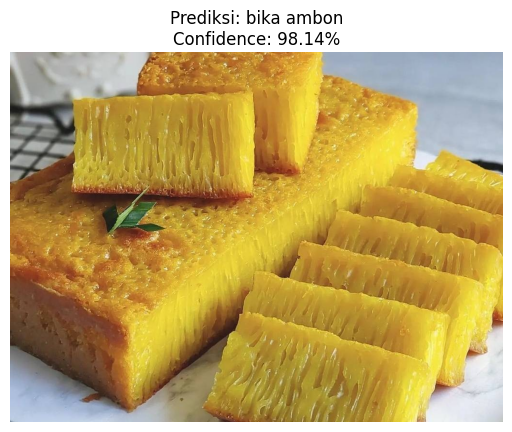

👉 ../predict_samples/test/kerak telur/test5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


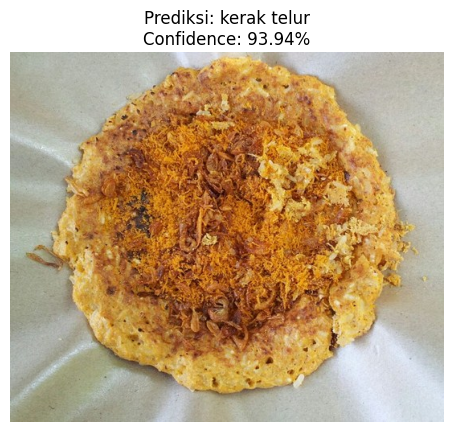

👉 ../predict_samples/test/papeda/test1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


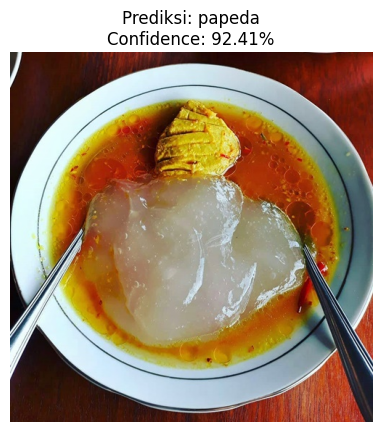

👉 ../predict_samples/test/plecing kangkung/test1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


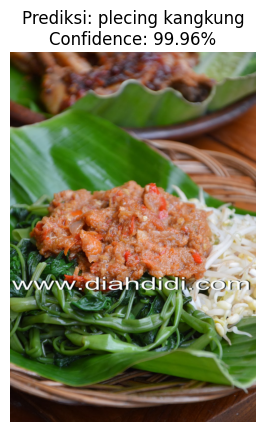

In [18]:
sample_paths = [
    "../predict_samples/test/bika ambon/test1.jpeg",
    "../predict_samples/test/kerak telur/test5.jpg",
    "../predict_samples/test/papeda/test1.jpg",
    "../predict_samples/test/plecing kangkung/test1.jpg",
]

for p in sample_paths:
    print("👉", p)
    predict_single_image(model, p, CLASS_NAMES_ORDER, img_size=IMG_SIZE)


## 13. Menyimpan Model Terbaik (.h5)

Model akhir kami disimpan sebagai file `.h5`:
`BestModel_CustomCNN_A_KERAS.h5`

File ini akan:
- Dimasukkan ke folder `models/`
- Diunggah ke repository GitHub
- Digunakan oleh aplikasi Streamlit untuk inference real-time (upload gambar → prediksi kelas makanan)

In [19]:
model.save("../models/BestModel_CustomCNN_A_KERAS.h5")
print("✅ Model disimpan sebagai BestModel_CustomCNN_A_KERAS.h5")

✅ Model disimpan sebagai BestModel_CustomCNN_A_KERAS.h5


## 14. Kesimpulan

1. Kami membangun CNN kustom tanpa pre-trained weights, sesuai aturan UTS.
2. Dataset terdiri dari 4 makanan daerah Indonesia: bika ambon, kerak telur, papeda, plecing kangkung.
3. Data diproses melalui tahapan normalisasi, batching, shuffle, dan prefetch.
4. Training selama 20 epoch menunjukkan akurasi yang tinggi pada training dan validation, tanpa overfitting signifikan.
5. Evaluasi pada test set menunjukkan model mampu melakukan generalisasi.
6. Confusion matrix dan classification report menunjukkan performa model per kelas.
7. Model dapat melakukan prediksi terhadap gambar baru (di luar dataset) dengan confidence tertentu.
8. Model telah diexport ke format `.h5` dan siap diintegrasikan ke aplikasi Streamlit untuk deployment.

Tahap berikutnya: implementasi antarmuka Streamlit dan deploy ke Streamlit Cloud.

